In [21]:
import pandas as pd
import ast

ENTITY_WEIGHTS = {
    "DISEASE": 2.0,
    "CHEMICAL": 1.5,
    "PROCEDURE": 1.0,
    "SYMPTOM": 1.0,
    "DATE": 0.5
}

FEATURE_WEIGHTS = {
    "has_blood": 2.0,
    "has_diarrhea": 1.5,
    "has_pain": 1.5,
    "has_fever": 1.5,
    "has_weight_loss": 1.5,
    "temporal_recent": 1.0,
    "has_er": 2.0,
    "has_procedure": 1.5,
}

df = pd.read_csv("../data/processed/ibd_ner_features_final.csv")

def compute_risk(row):
    total_score = 0.0

    # Parsear entidades
    for col in ["entities_spacy", "entities_scispacy_bc5cdr"]:
        try:
            entities = ast.literal_eval(row[col])
            if isinstance(entities, list):
                for ent in entities:
                    if len(ent) >= 3:
                        label = ent[2].upper()
                        total_score += ENTITY_WEIGHTS.get(label, 0)
        except Exception:
            pass
    
    # Añadir pesos de features binarias
    for feat, weight in FEATURE_WEIGHTS.items():
        if feat in row and row[feat] == 1:
            total_score += weight
    
    # Asignar clase de riesgo
    if total_score < 4:
        risk_class = "low"
    elif total_score < 8:
        risk_class = "medium"
    else:
        risk_class = "high"
    
    return pd.Series({"risk_score": total_score, "risk_class": risk_class})

df[["risk_score", "risk_class"]] = df.apply(compute_risk, axis=1)
df.to_csv("../data/processed/ibd_ner_features_final_with_risk.csv", index=False)

In [22]:
print(df["risk_class"].value_counts())

risk_class
low       81858
high      60492
medium    41397
Name: count, dtype: int64


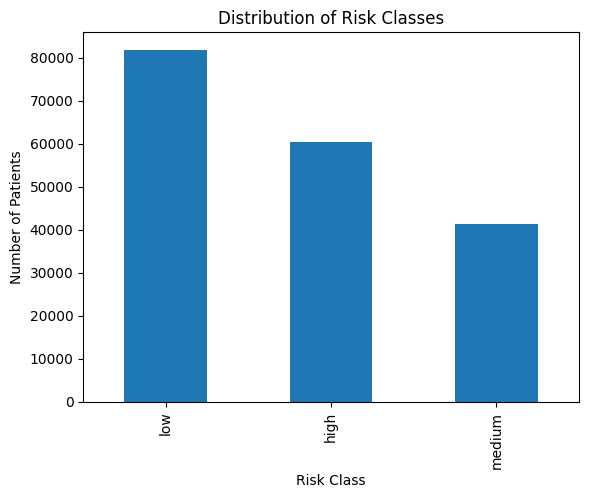

In [25]:
import matplotlib.pyplot as plt

df["risk_class"].value_counts().plot(kind='bar')
plt.title("Distribution of Risk Classes")
plt.xlabel("Risk Class")
plt.ylabel("Number of Patients")
plt.show()